In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du

from data.DataUtils import get_ncmapss_dataloaders

from models import TransformerEncoder, TransformerDecoder

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
trainloader, testloader = get_ncmapss_dataloaders(1, 10, 128, 8, subsampled=True, shuffle_train=False)

In [4]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
training_features = [True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               False, False, False, False, False, False, False, False, False, False,
               True, True, True, False]

ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X[:,:,training_features].shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 35]), Y Shape: torch.Size([128, 1])


In [5]:
dim = 16

enc = TransformerEncoder(input_dim=ex_X[:,:,training_features].shape[2], embed_dim=dim).to(device)
checkpoint = torch.load(f'./saved_models/enc_ncmapss_{dim}dim.pth')
print(checkpoint.keys())
enc.load_state_dict(checkpoint['model_state_dict'], strict=False)
enc.positional_embed.data = checkpoint['positional_embed']
for param in enc.parameters():
    param.requires_grad = False

dec = TransformerDecoder(output_dim=ex_X[:,:,training_features].shape[2], embed_dim=dim).to(device)
dec.load_state_dict(torch.load(f'./saved_models/dec_ncmapss_{dim}dim.pth'))
for param in dec.parameters():
    param.requires_grad = False

dict_keys(['model_state_dict', 'positional_embed'])


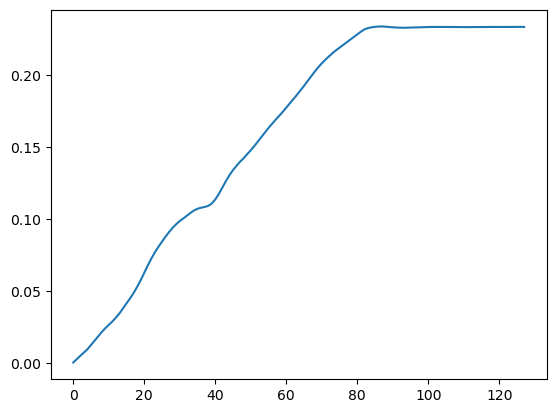

In [6]:
plt.plot(ex_X[:,-1,0])

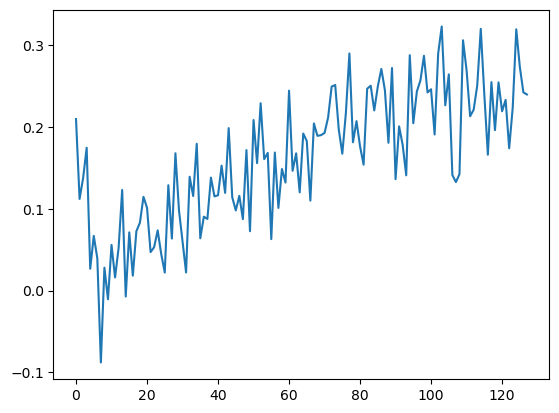

In [7]:
plt.plot(dec(enc(ex_X[:,:,training_features].to(torch.float32).to(device))).cpu().numpy()[:,0])

In [8]:
from models import StateTransition

In [9]:
ex_z = enc(ex_X[:,:,training_features].to(torch.float32).to(device))

In [10]:
transition = StateTransition(dim, hidden_dim=64).to(device)
transition(ex_z, 1)

tensor([[ 0.0008, -0.0999,  0.0108,  ..., -0.0319, -0.0631, -0.0084],
        [-0.0574, -0.1052, -0.0282,  ..., -0.0991, -0.0846, -0.0799],
        [-0.0895, -0.2002,  0.0115,  ..., -0.0140, -0.1602, -0.1156],
        ...,
        [ 0.0608, -0.0279, -0.0460,  ...,  0.0829,  0.1149, -0.2615],
        [ 0.1083,  0.0611,  0.0421,  ...,  0.1451,  0.0254, -0.3374],
        [ 0.0390,  0.0238,  0.1515,  ...,  0.0411,  0.0156, -0.0103]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
objective = nn.MSELoss()
params = transition.parameters()
    # optimizer
optim = torch.optim.Adam(params, lr=1e-4)
losses = []

n_epochs = 3

for epoch_num in range(n_epochs):
    for i, (X, y) in enumerate(tqdm(trainloader)):
        optim.zero_grad()
        X = X[:,:,training_features].to(torch.float32).to(device)
        n_steps = int(np.random.uniform(1, 10))
        while (i) * trainloader.batch_size + X.shape[0] + n_steps > len(trainloader.dataset): # if we go beyond length of the dataset
            n_steps -= 1
            
        valid_steps = y >= n_steps # make sure this is right?
        valid_steps = valid_steps.squeeze()

        if not torch.any(valid_steps):
            continue
        
        # future_data = trainloader.dataset[(i) * trainloader.batch_size + n_steps : (i) * trainloader.batch_size + X.shape[0] + n_steps][0]
        
        future_idx = list(range(i * trainloader.batch_size + n_steps, i * trainloader.batch_size + X.shape[0] + n_steps))
        future_data = [trainloader.dataset[idx][0] for idx in future_idx]
        # print(future_data.shape)
        future_data = torch.tensor(np.array(future_data))
        future_data = future_data[:,-1,training_features]
        
        z = enc(X[valid_steps.squeeze(),:,:])
        z.requires_grad_(True)
        next_z = transition(z, n_steps)
        xhat = dec(next_z)
        
        future_data = future_data[valid_steps, :].to(torch.float32).to(device)
        # true_future = torch.tensor(future_data[valid_steps, :], requires_grad=True).to(torch.float32).to(device)
        loss = objective(xhat, future_data) # how do we get the data ahead in time?
        loss.backward()
        optim.step()
        
        first_params = next(iter(transition.parameters()))
        # print(f'Parameter: {first_params.data[:,0]}')
        losses.append(loss.item())
        if torch.isnan(loss):
            print("NaN Loss")
            print(future_data, n_steps, valid_steps)
            break
        # print(loss.item())
        
    print(f"Epoch: {epoch_num+1}, loss: {np.mean(losses[-100:])}")

100%|██████████| 3834/3834 [08:06<00:00,  7.89it/s]


Epoch: 1, loss: 0.011350546884350478


100%|██████████| 3834/3834 [08:07<00:00,  7.86it/s]


Epoch: 2, loss: 0.011930799344554543


100%|██████████| 3834/3834 [08:08<00:00,  7.85it/s]

Epoch: 3, loss: 0.010760764186270535


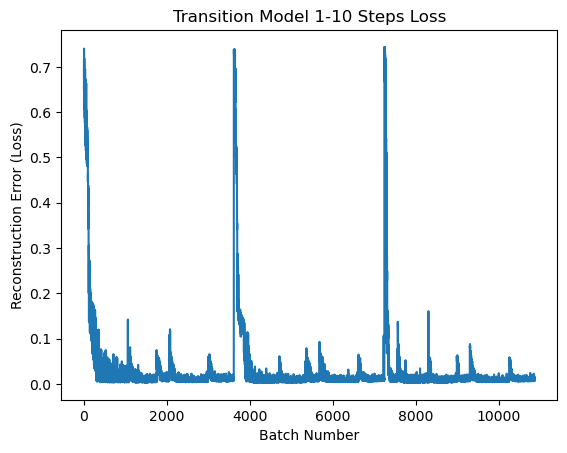

In [24]:
plt.title("Transition Model 1-10 Steps Loss")
plt.ylabel("Reconstruction Error (Loss)")
plt.xlabel("Batch Number")
plt.plot(losses)

In [25]:
losses = np.array(losses)
print(np.mean(losses[~np.isnan(losses)]))

0.031057840539711935


In [26]:
torch.save(transition.state_dict(), './saved_models/10step_transition_ncmapss_16d.pth')

In [28]:
objective = nn.MSELoss()
losses = []

for i, (X, y) in enumerate(tqdm(testloader)):
    X = X[:,:,training_features].to(torch.float32).to(device)
    n_steps = int(np.random.uniform(1, 10))
    n_steps = 10
    while (i) * testloader.batch_size + X.shape[0] + n_steps > len(testloader.dataset): # if we go beyond length of the dataset
        n_steps -= 1
        
    valid_steps = y >= n_steps # make sure this is right?
    valid_steps = valid_steps.squeeze()

    if not torch.any(valid_steps):
        continue
    
    # future_data = trainloader.dataset[(i) * trainloader.batch_size + n_steps : (i) * trainloader.batch_size + X.shape[0] + n_steps][0]
    
    future_idx = list(range(i * testloader.batch_size + n_steps, i * testloader.batch_size + X.shape[0] + n_steps))
    future_data = [testloader.dataset[idx][0] for idx in future_idx]
    # print(future_data.shape)
    future_data = torch.tensor(np.array(future_data))
    future_data = future_data[:,-1,training_features]
    
    z = enc(X[valid_steps.squeeze(),:,:])
    next_z = transition(z, n_steps)
    xhat = dec(next_z)
    
    future_data = future_data[valid_steps, :].to(torch.float32).to(device)
    loss = objective(xhat, future_data) # how do we get the data ahead in time?
    
    first_params = next(iter(transition.parameters()))
    # print(f'Parameter: {first_params.data[:,0]}')
    losses.append(loss.item())
    if torch.isnan(loss):
        print("NaN Loss")
        print(future_data, n_steps, valid_steps)
        break
    
print(f"Transition error: {np.mean(losses)}")

100%|██████████| 2137/2137 [04:05<00:00,  8.72it/s]

Transition error: 0.3060957497926919


In [19]:
losses = np.array(losses)
print(np.mean(losses[~np.isnan(losses)]))

0.29359711467257243
